In [80]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from pandas import Timestamp
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua
import trajectory as trj

import h5py
import ray
# ray.init(num_cpus=7)


In [49]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def drop_dims(input_array):
    input_array = np.array(input_array)
    dim = []
    for i in list(np.shape(input_array)):
        if i != 1:
            dim.append(i)
    return input_array.reshape(dim)

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

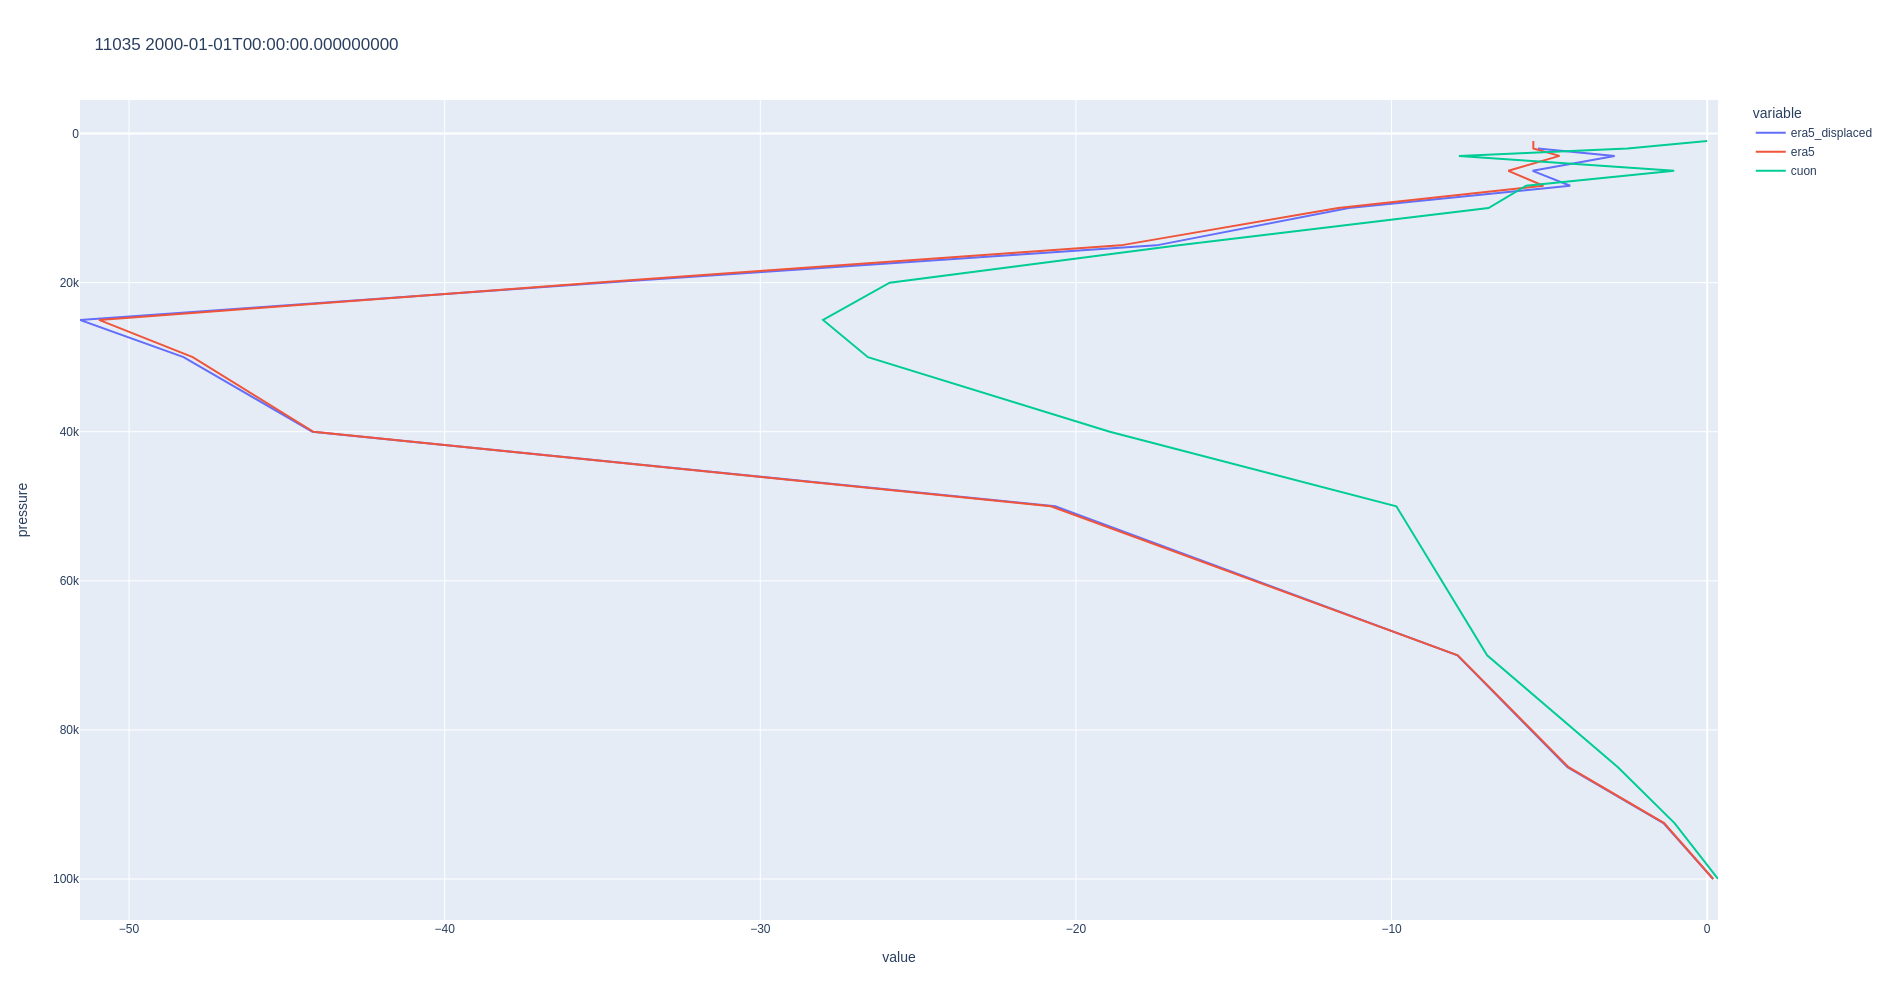

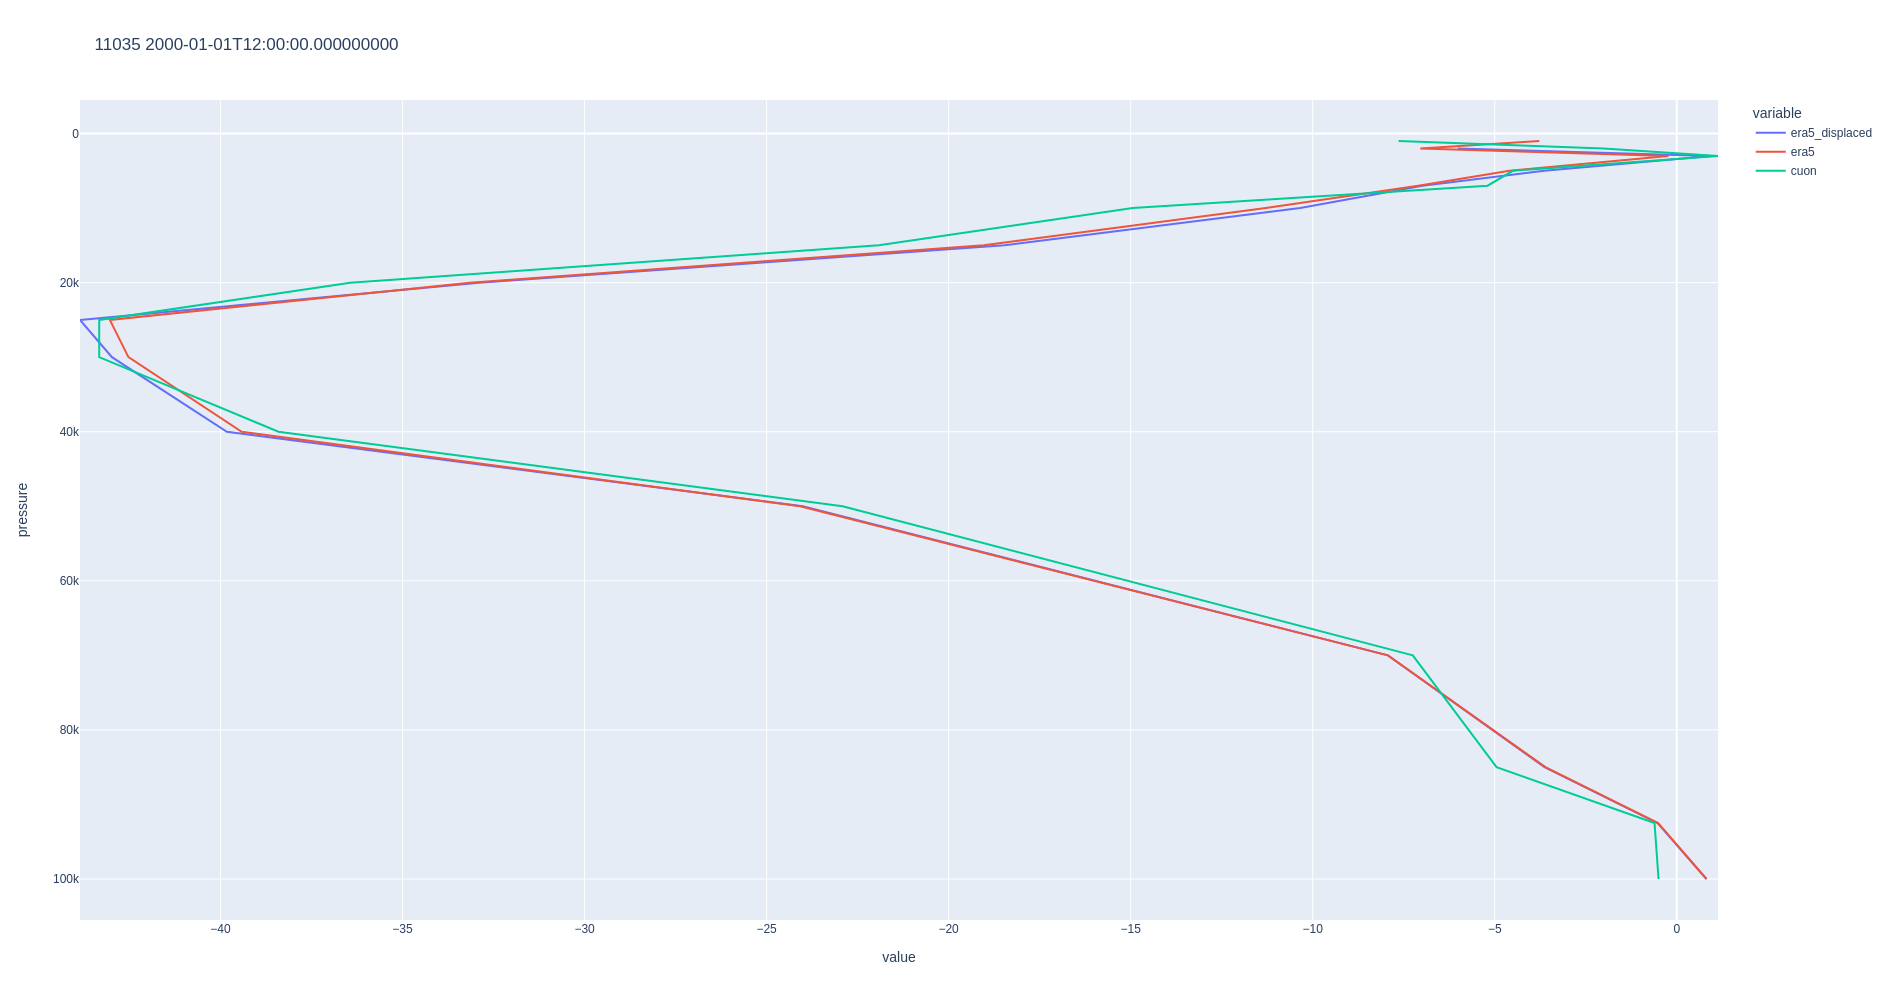

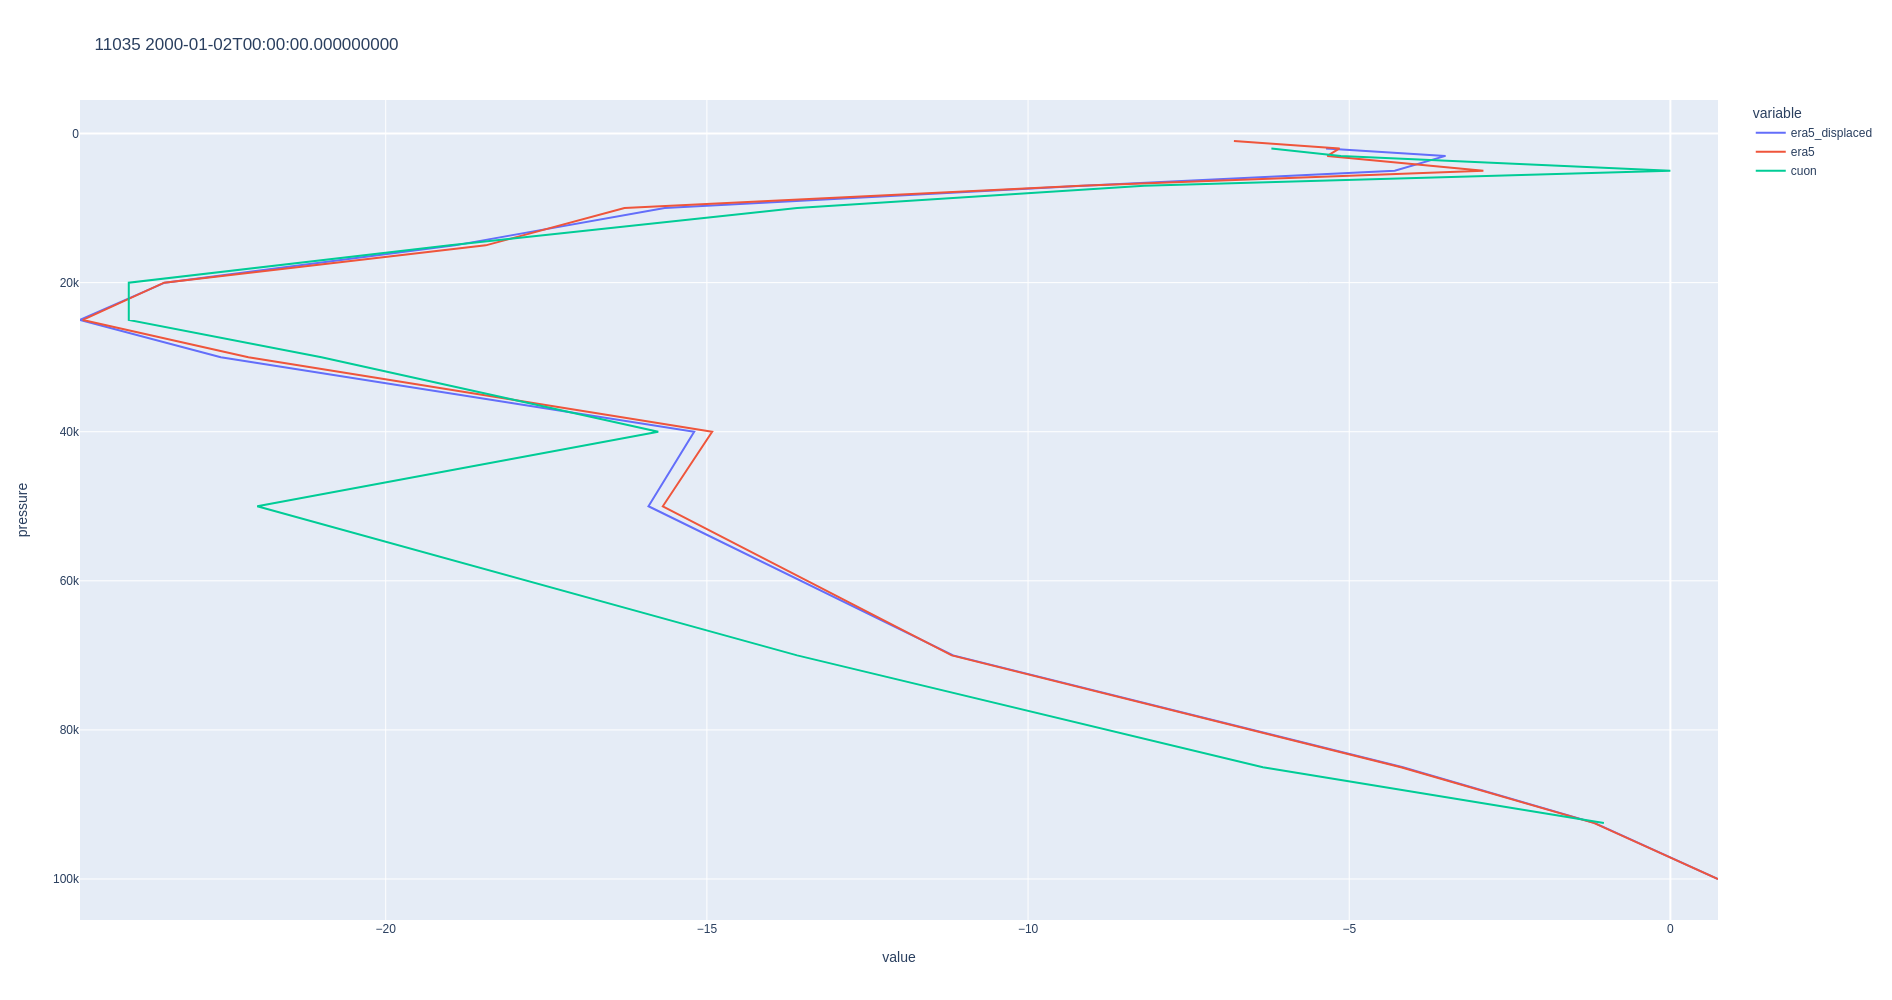

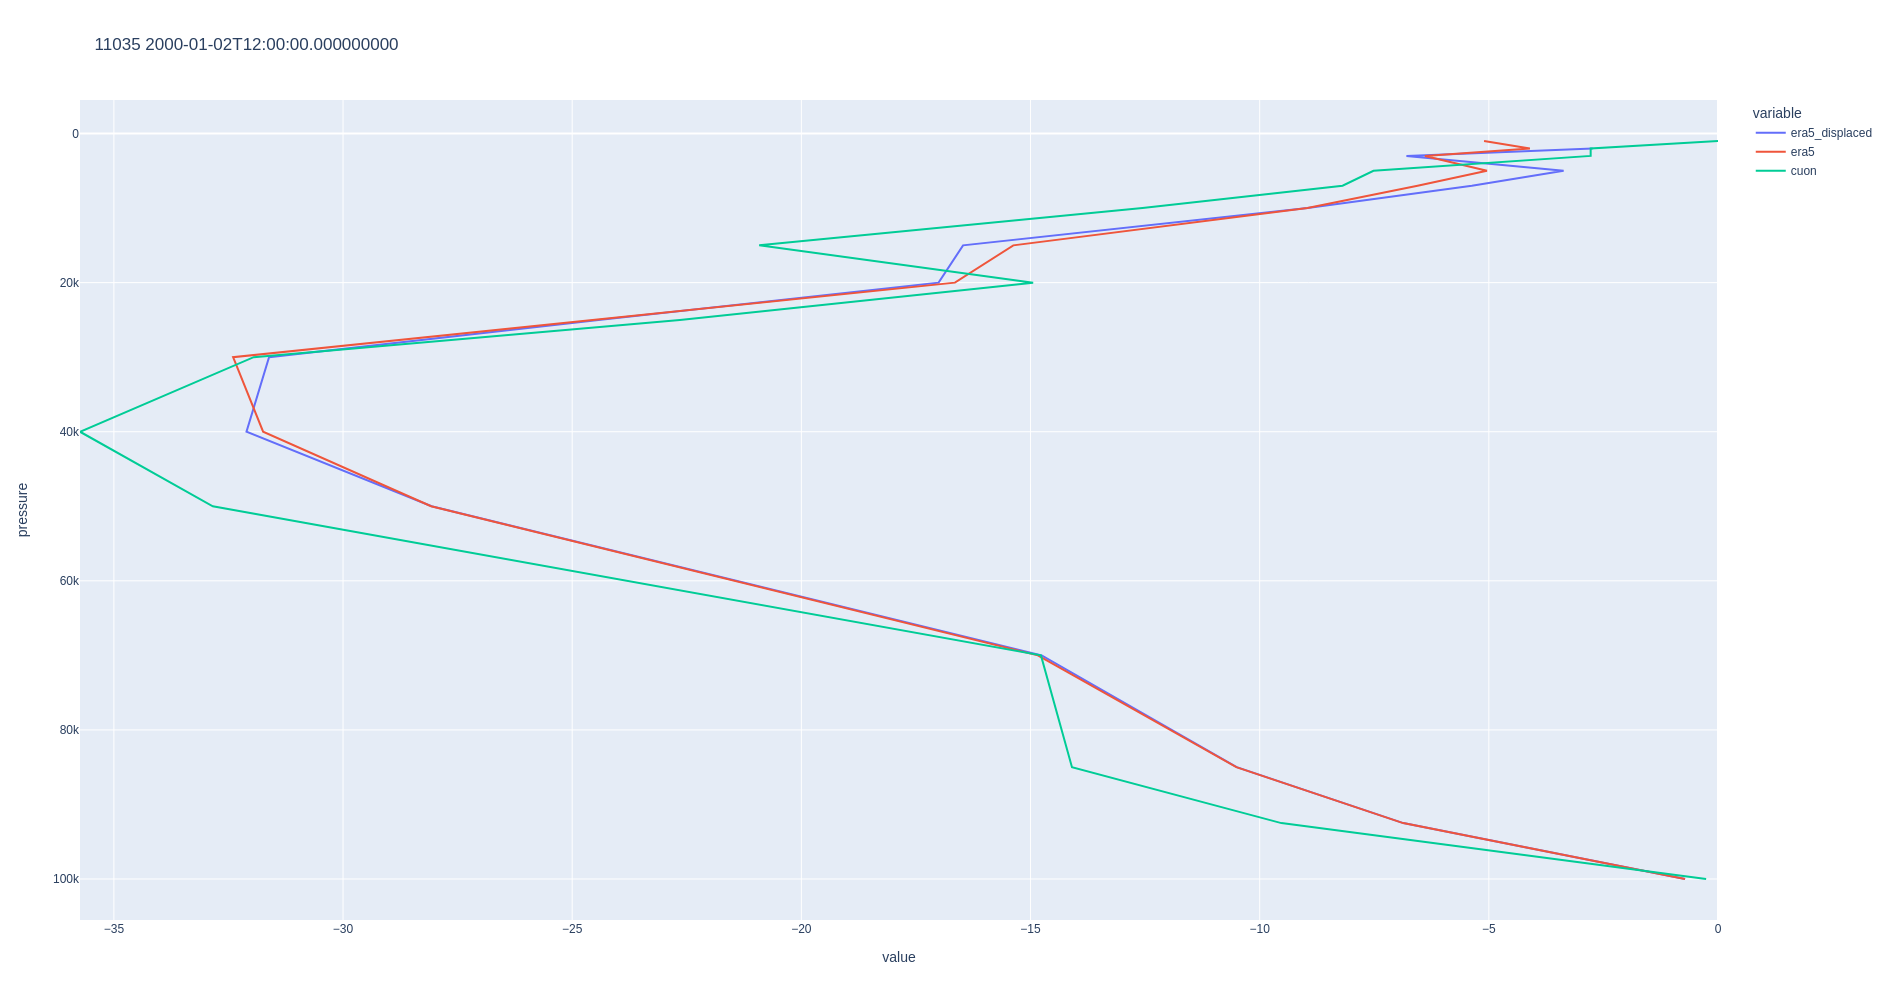

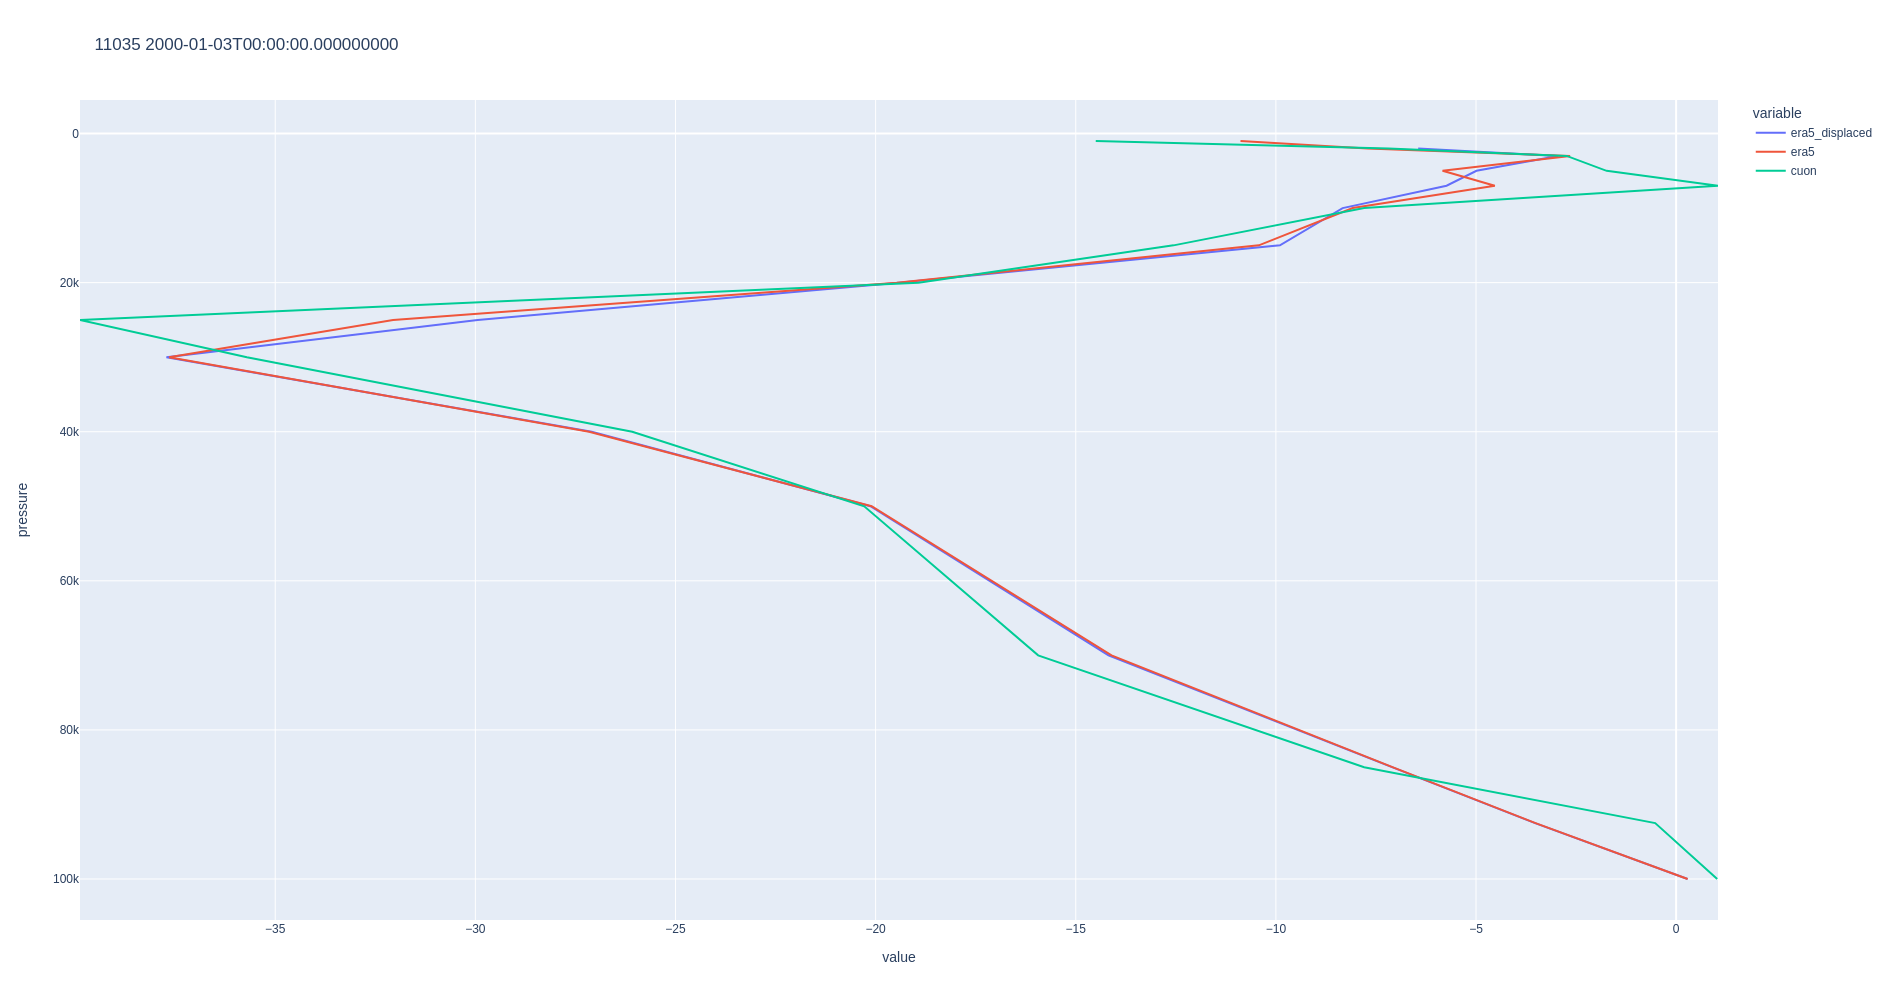

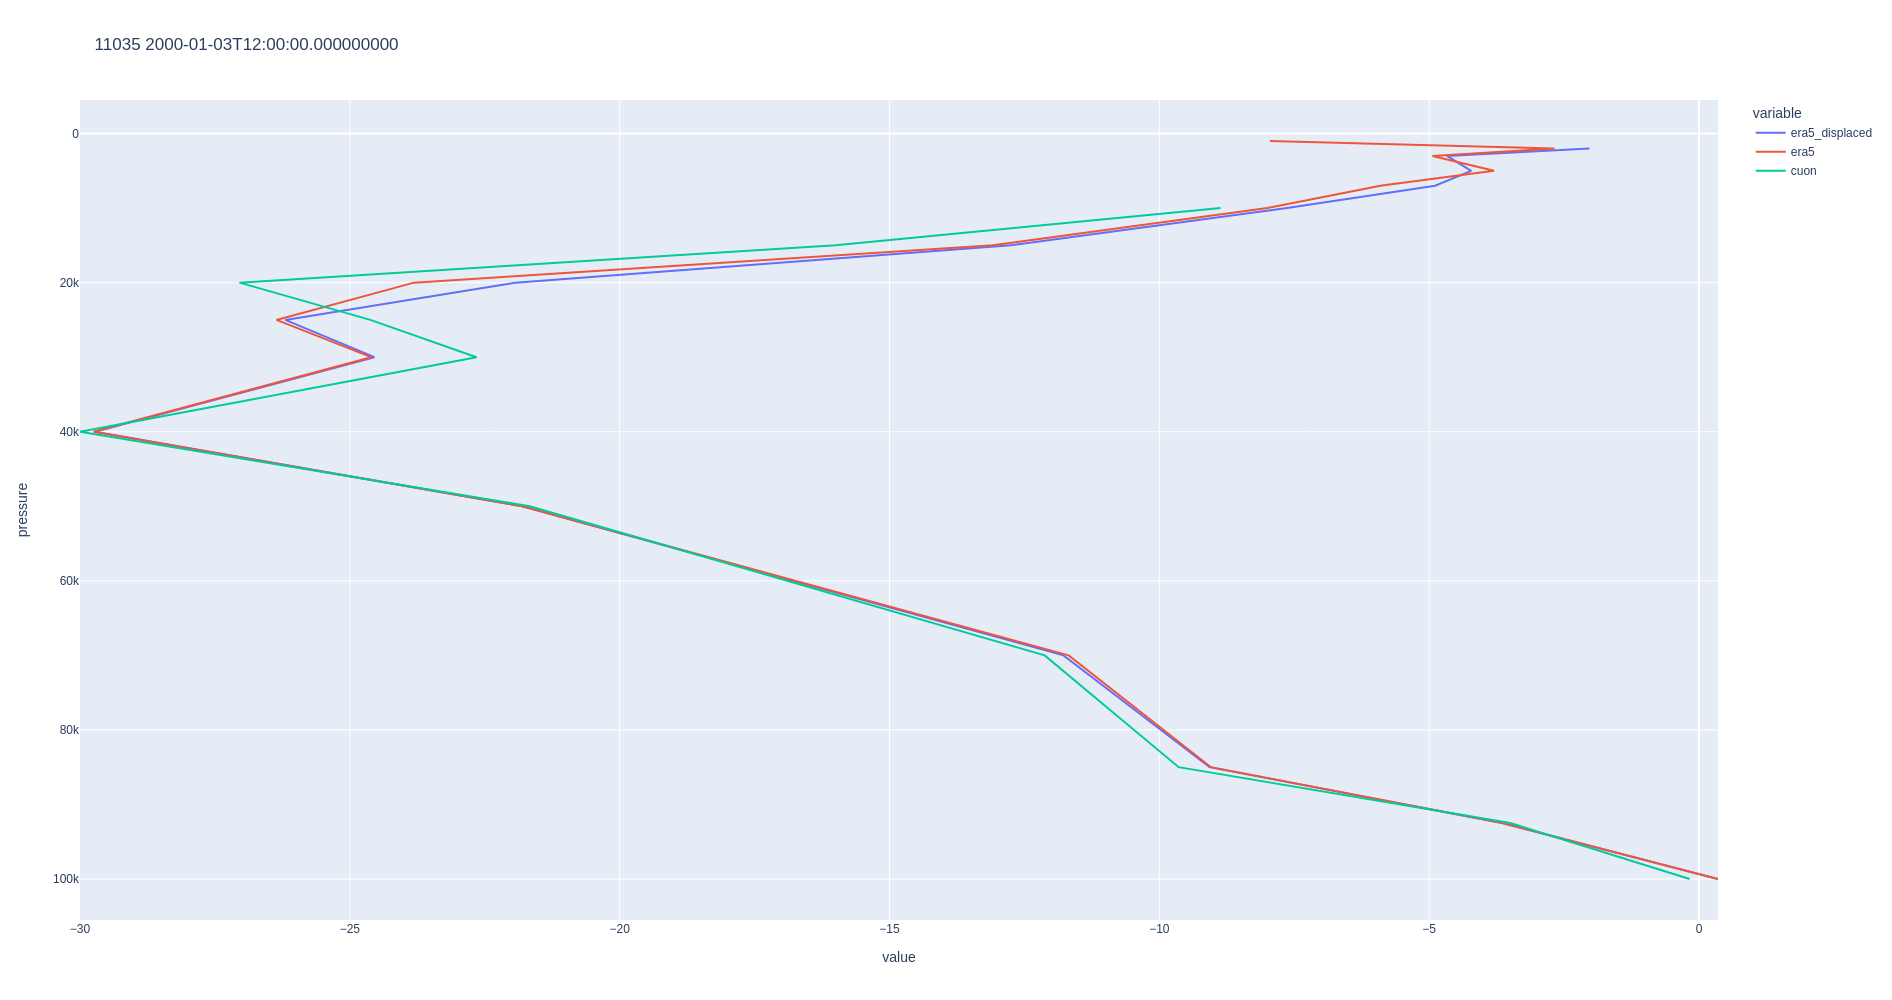

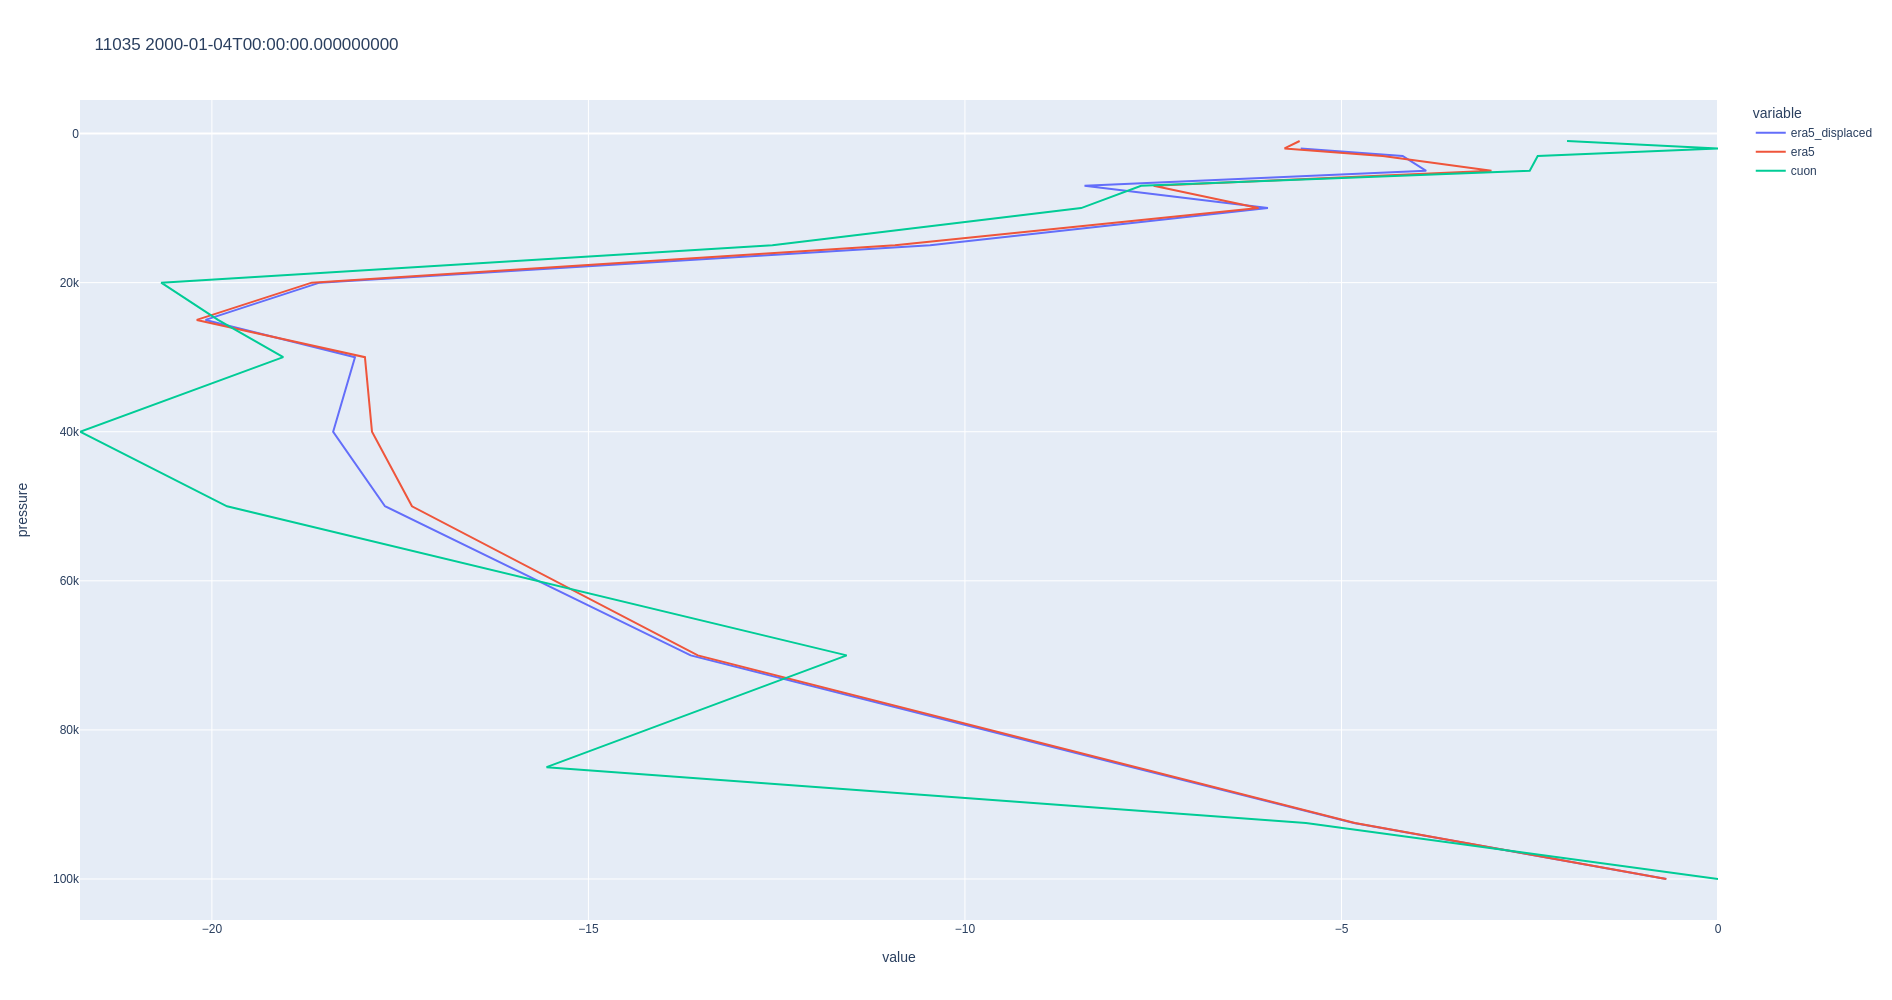

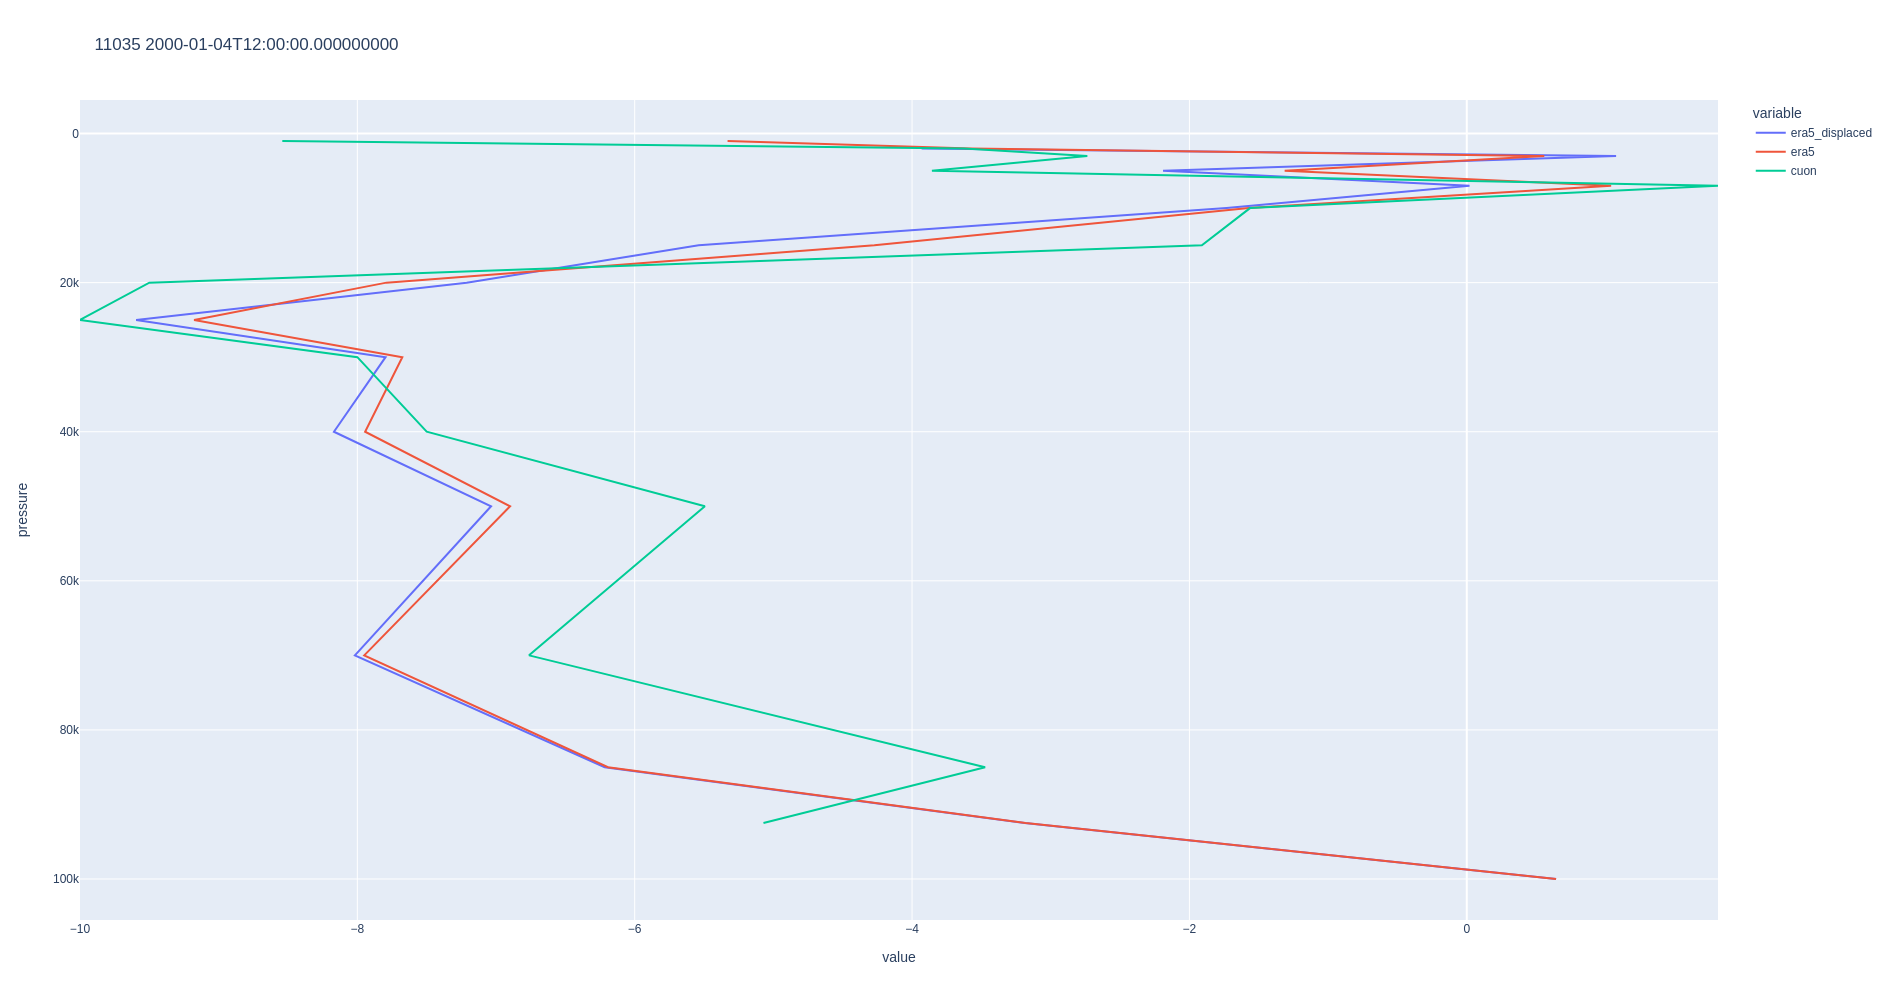

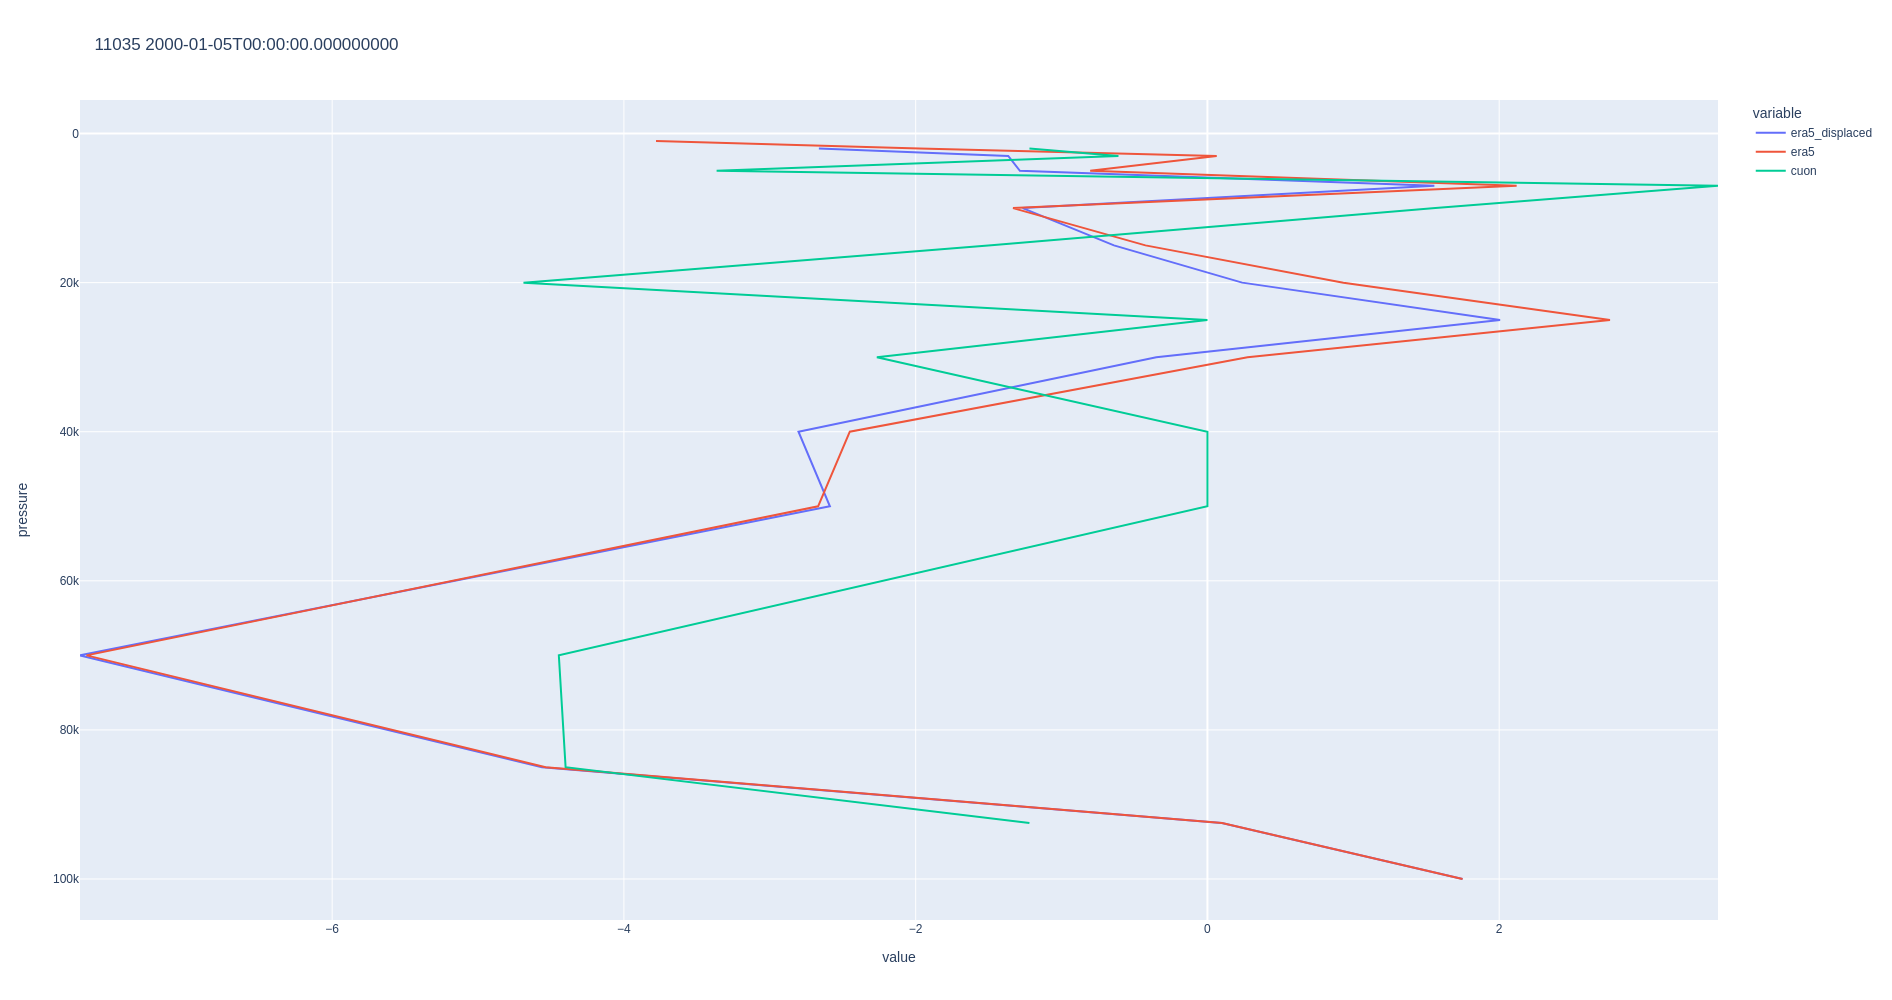

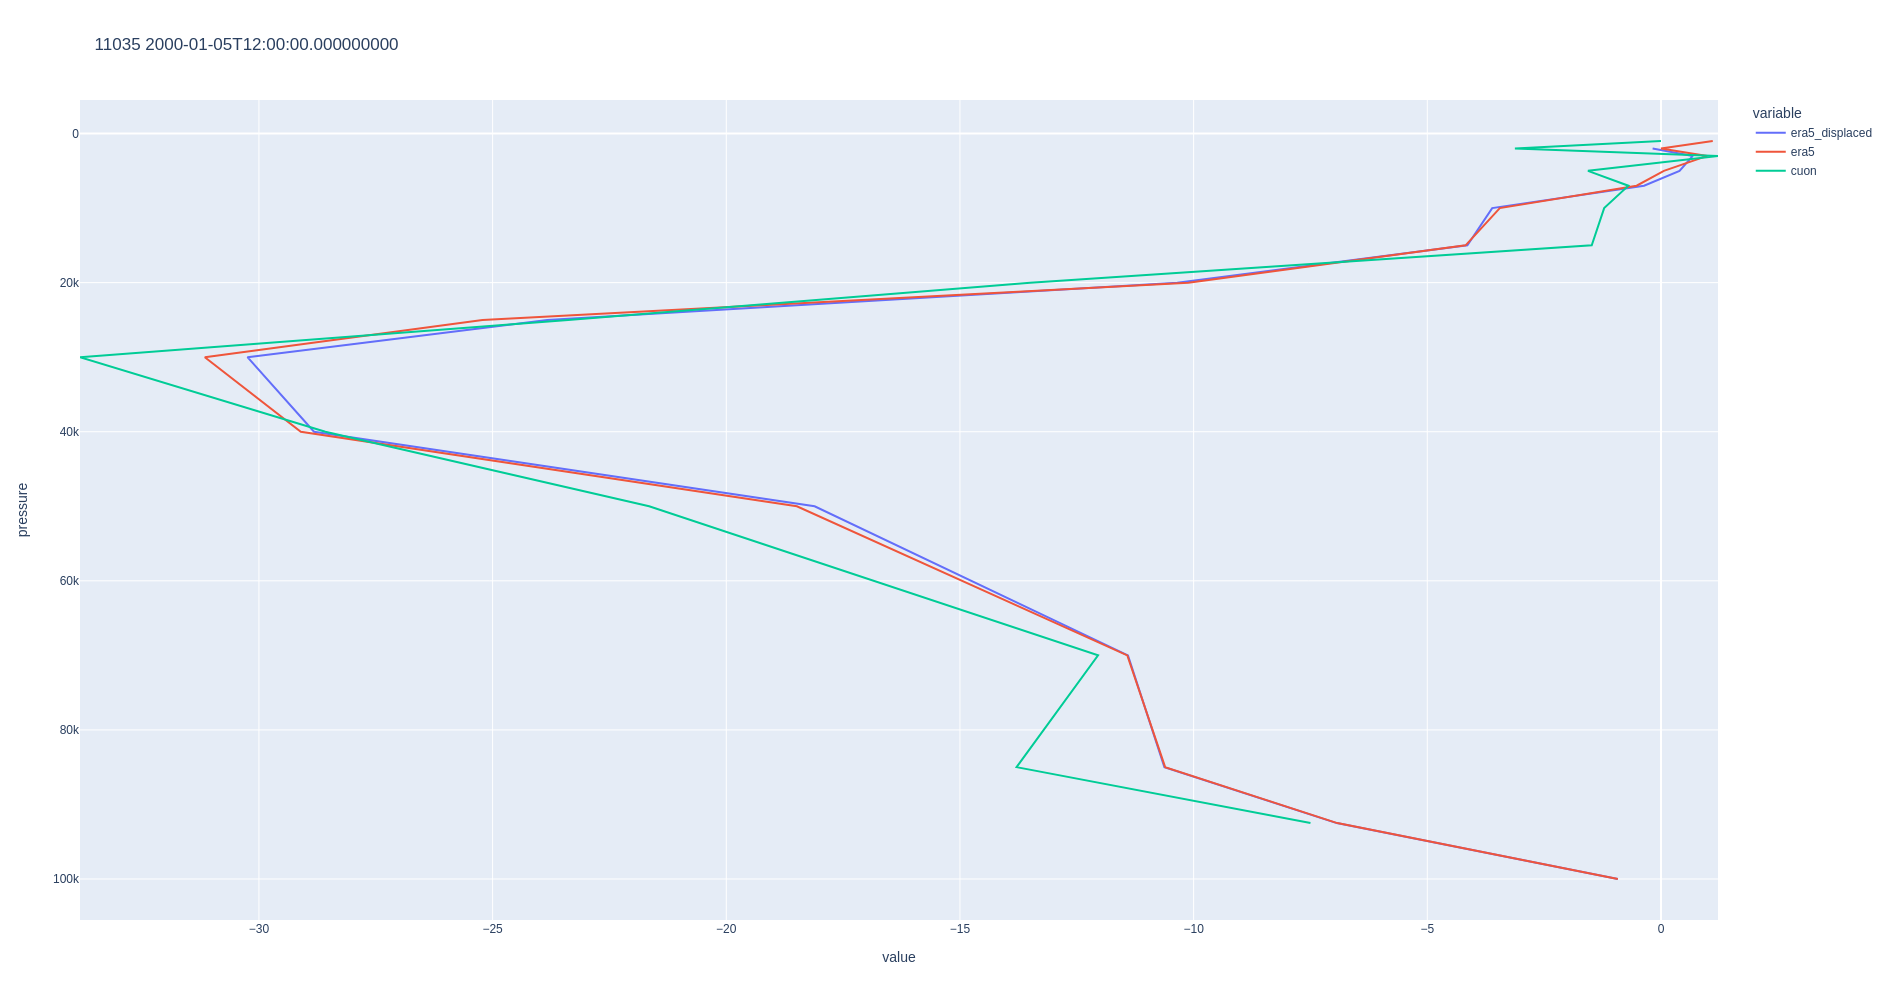

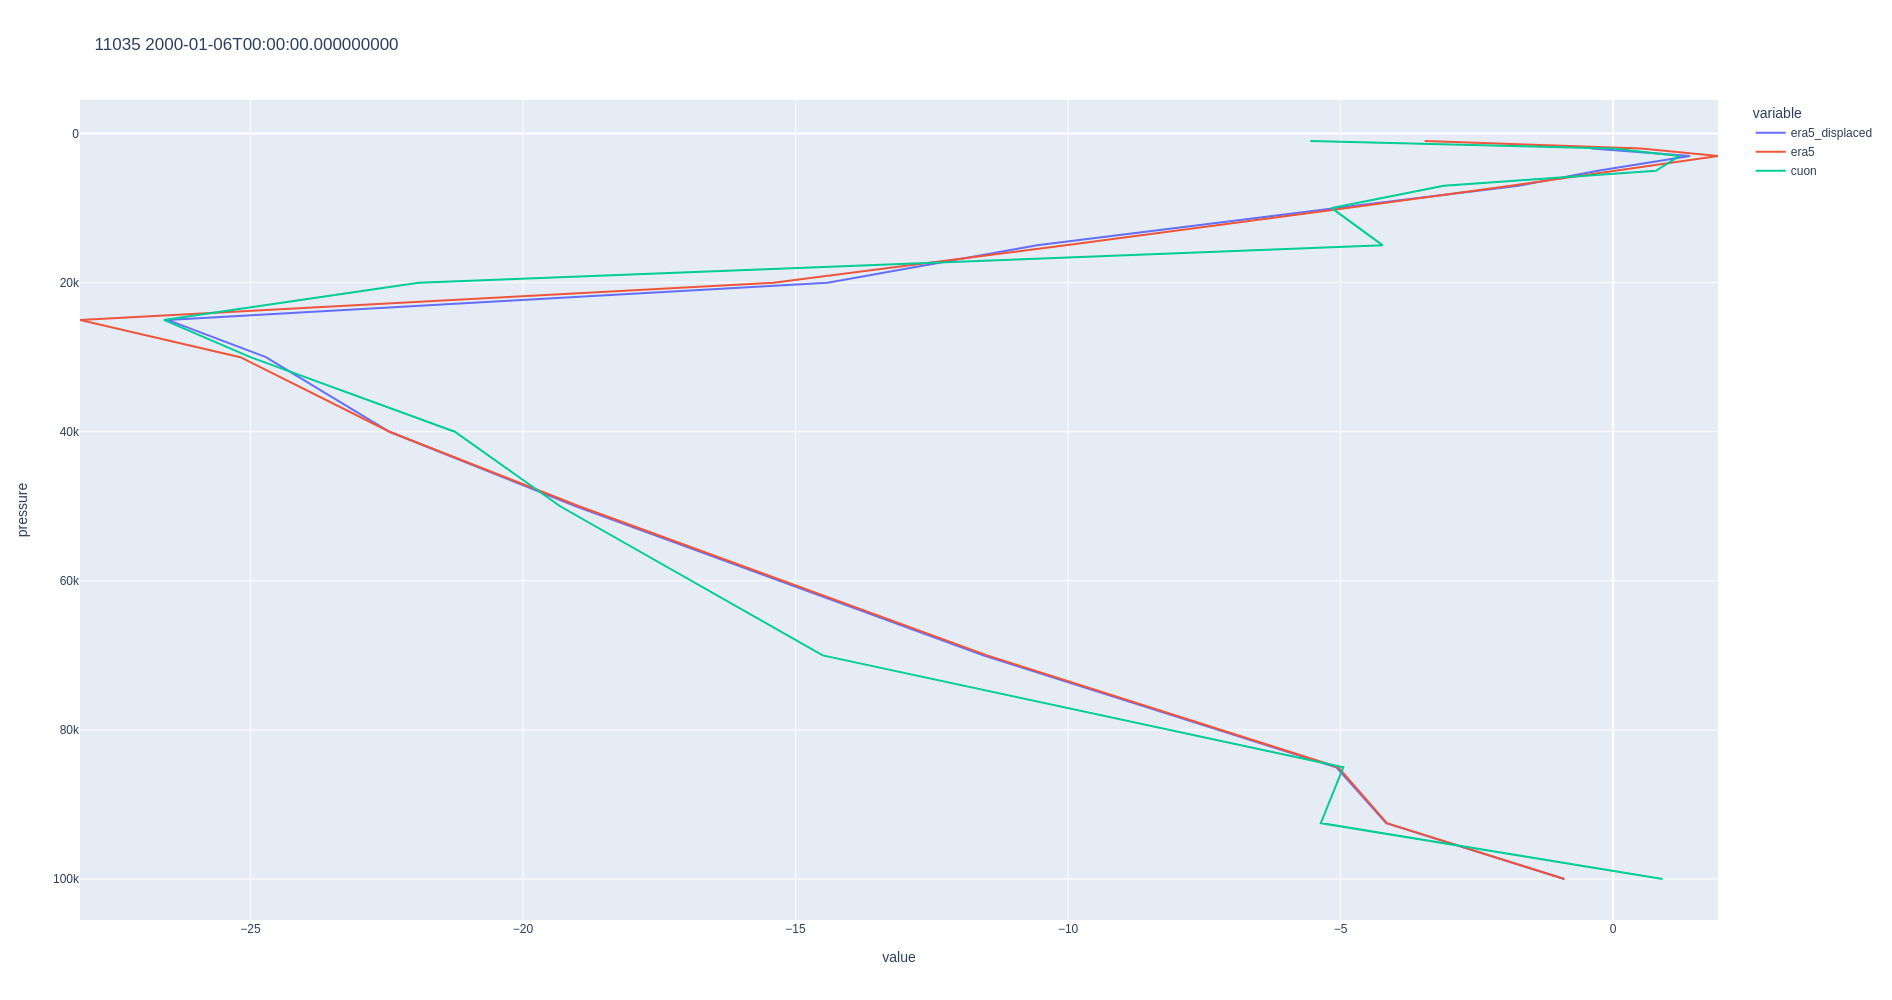

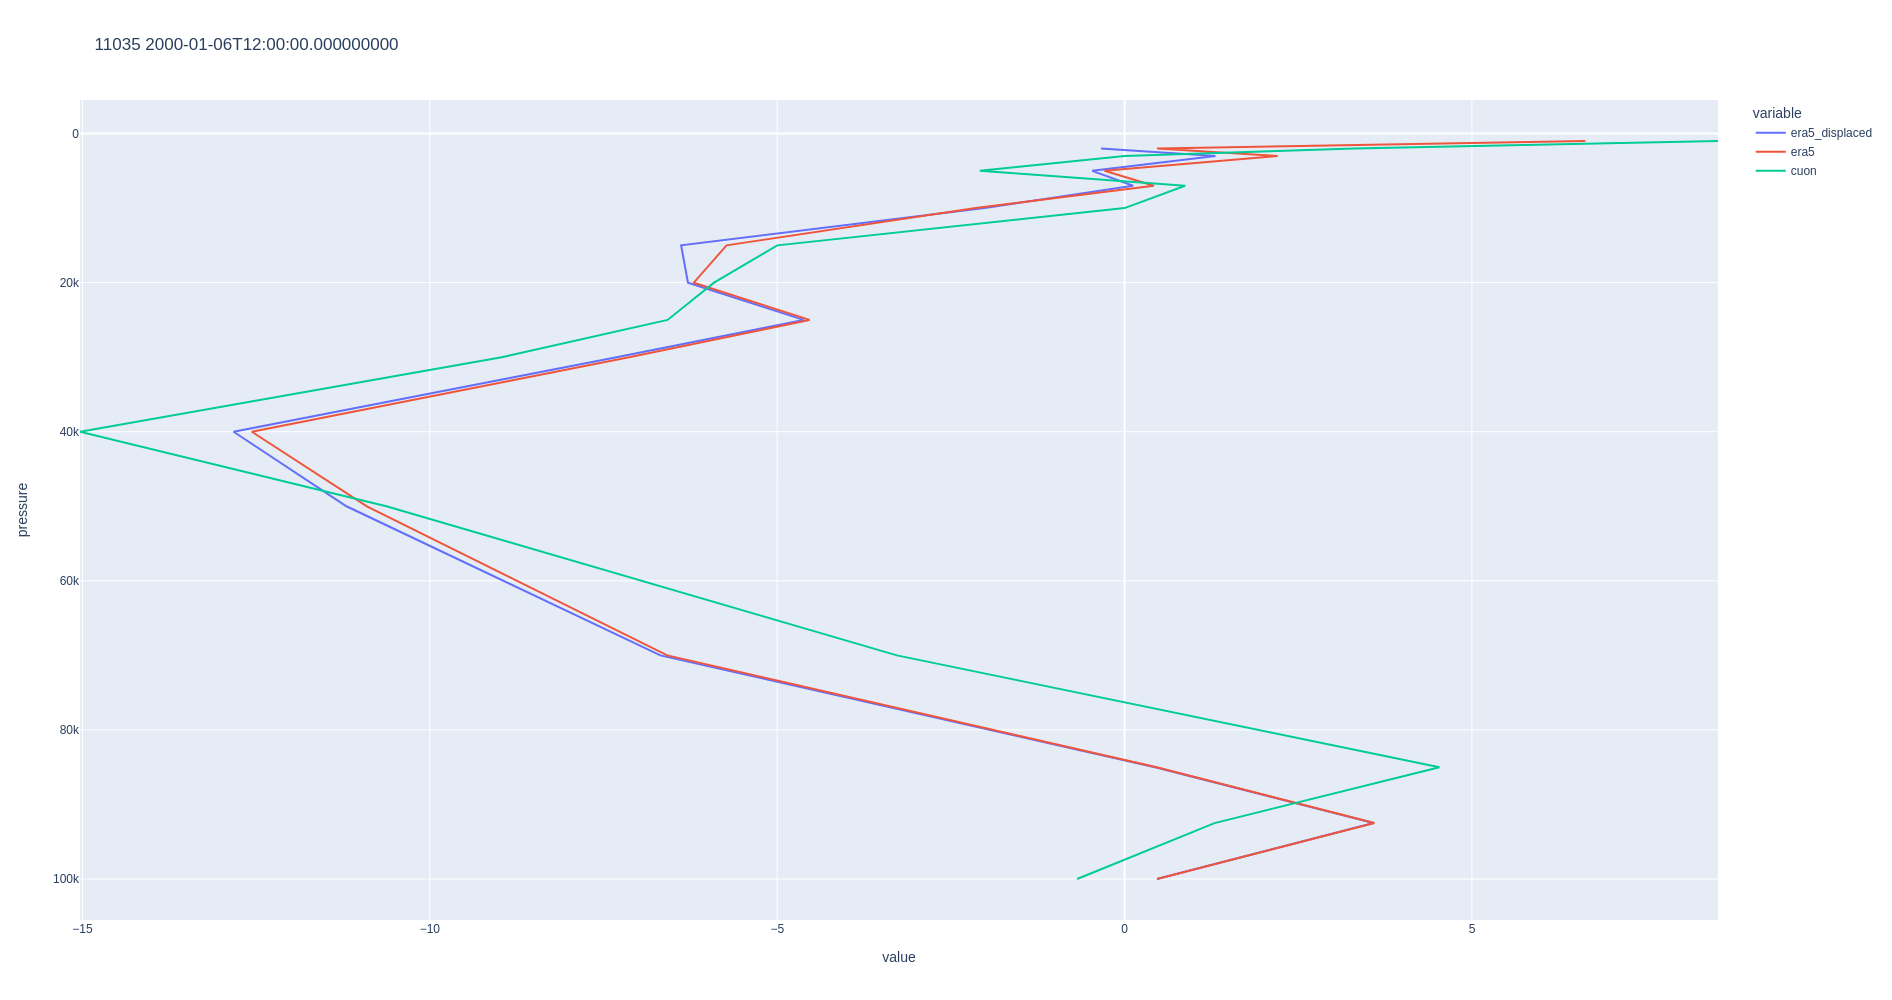

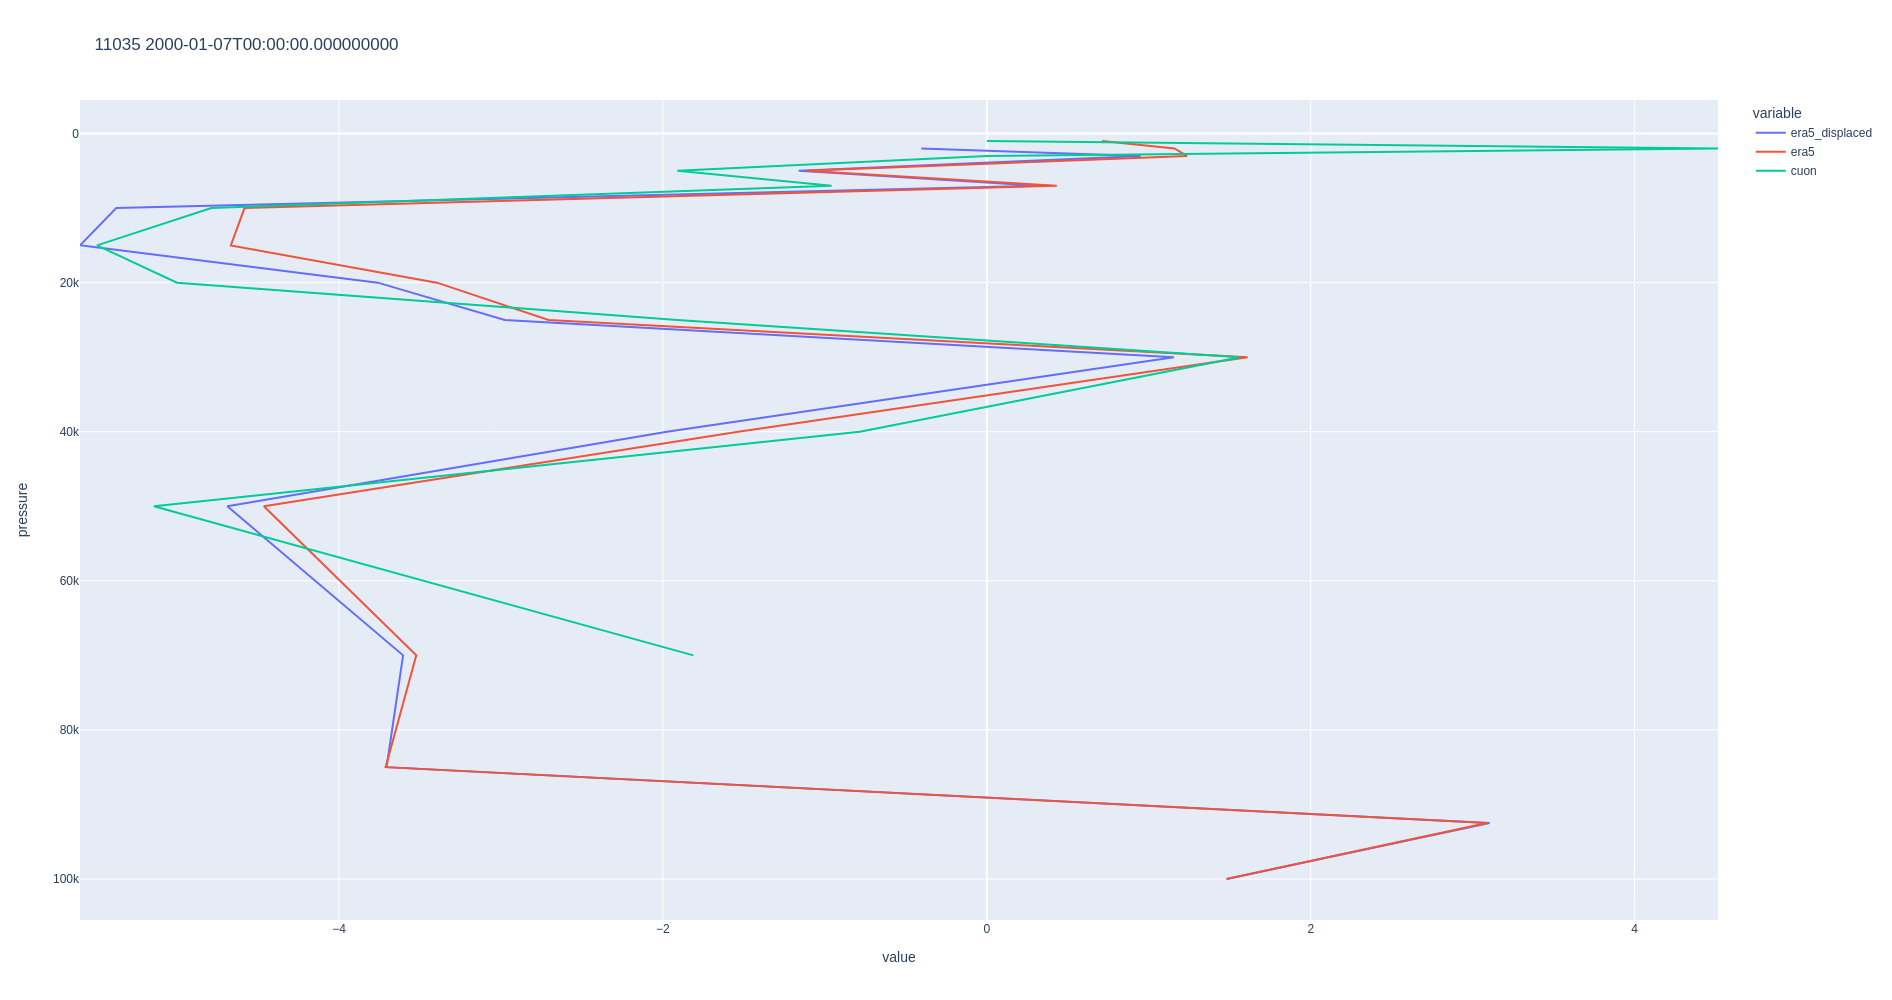

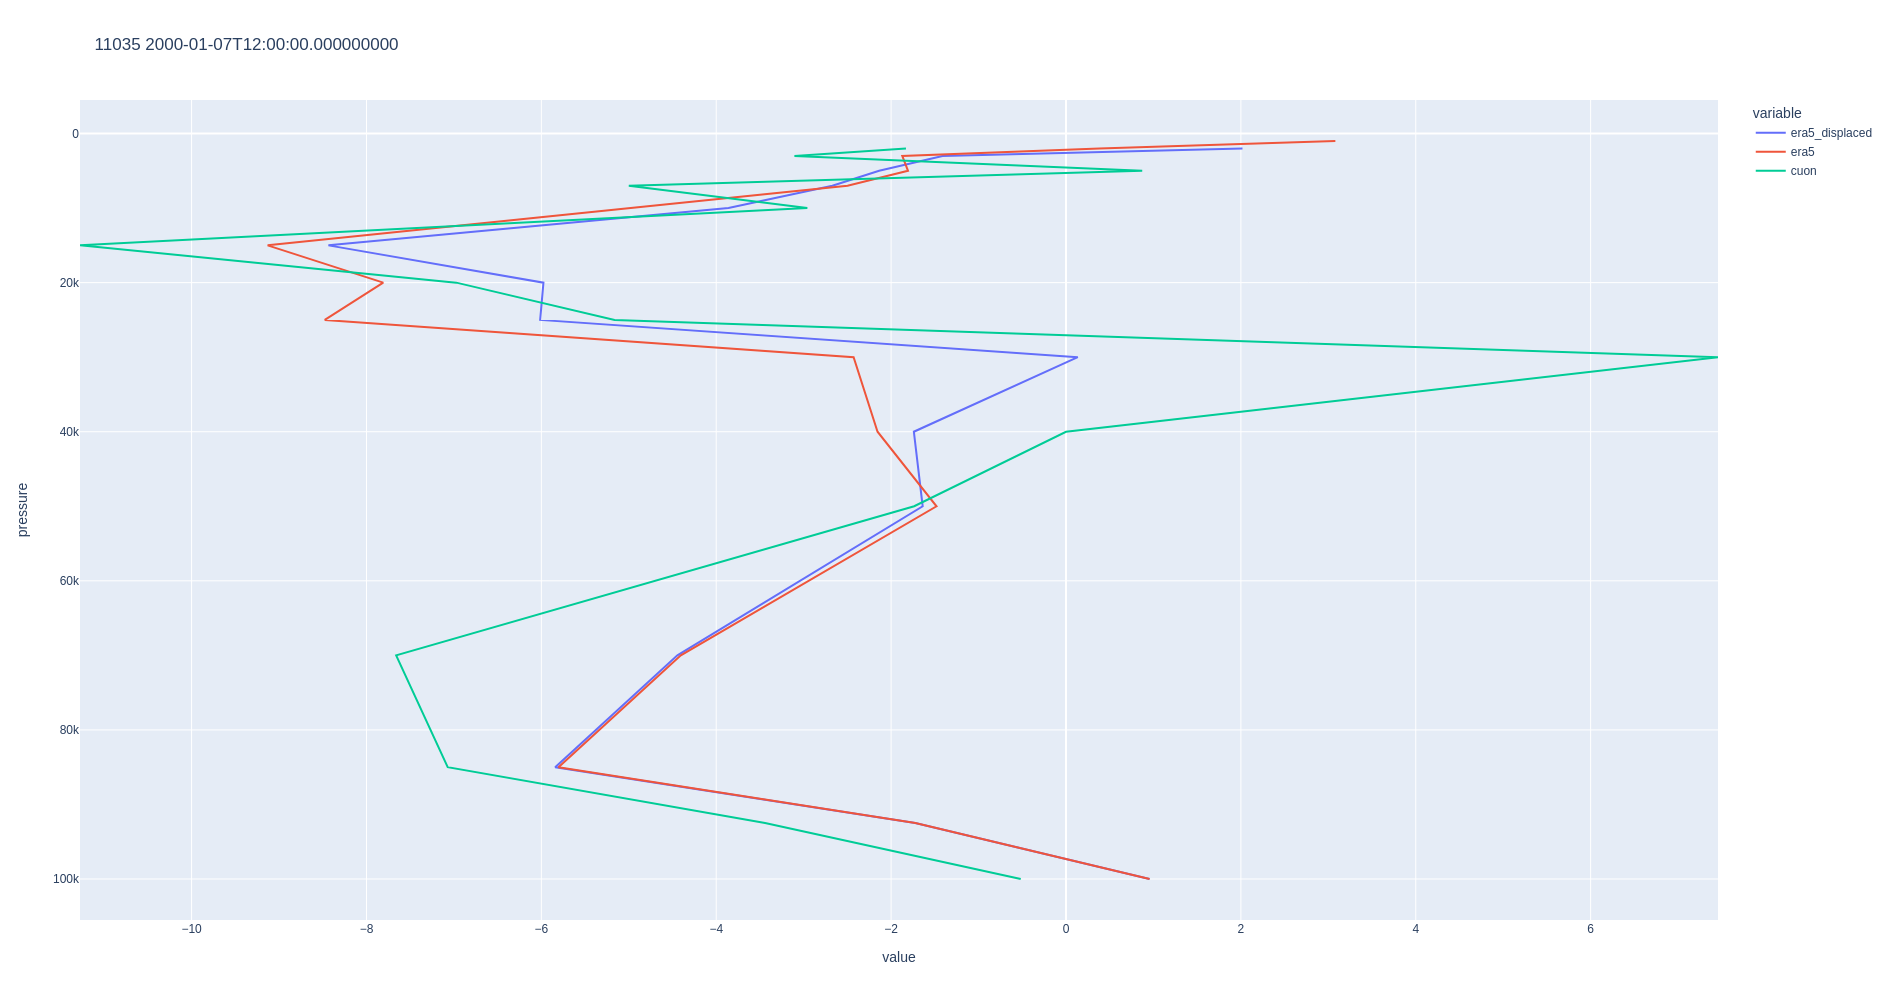

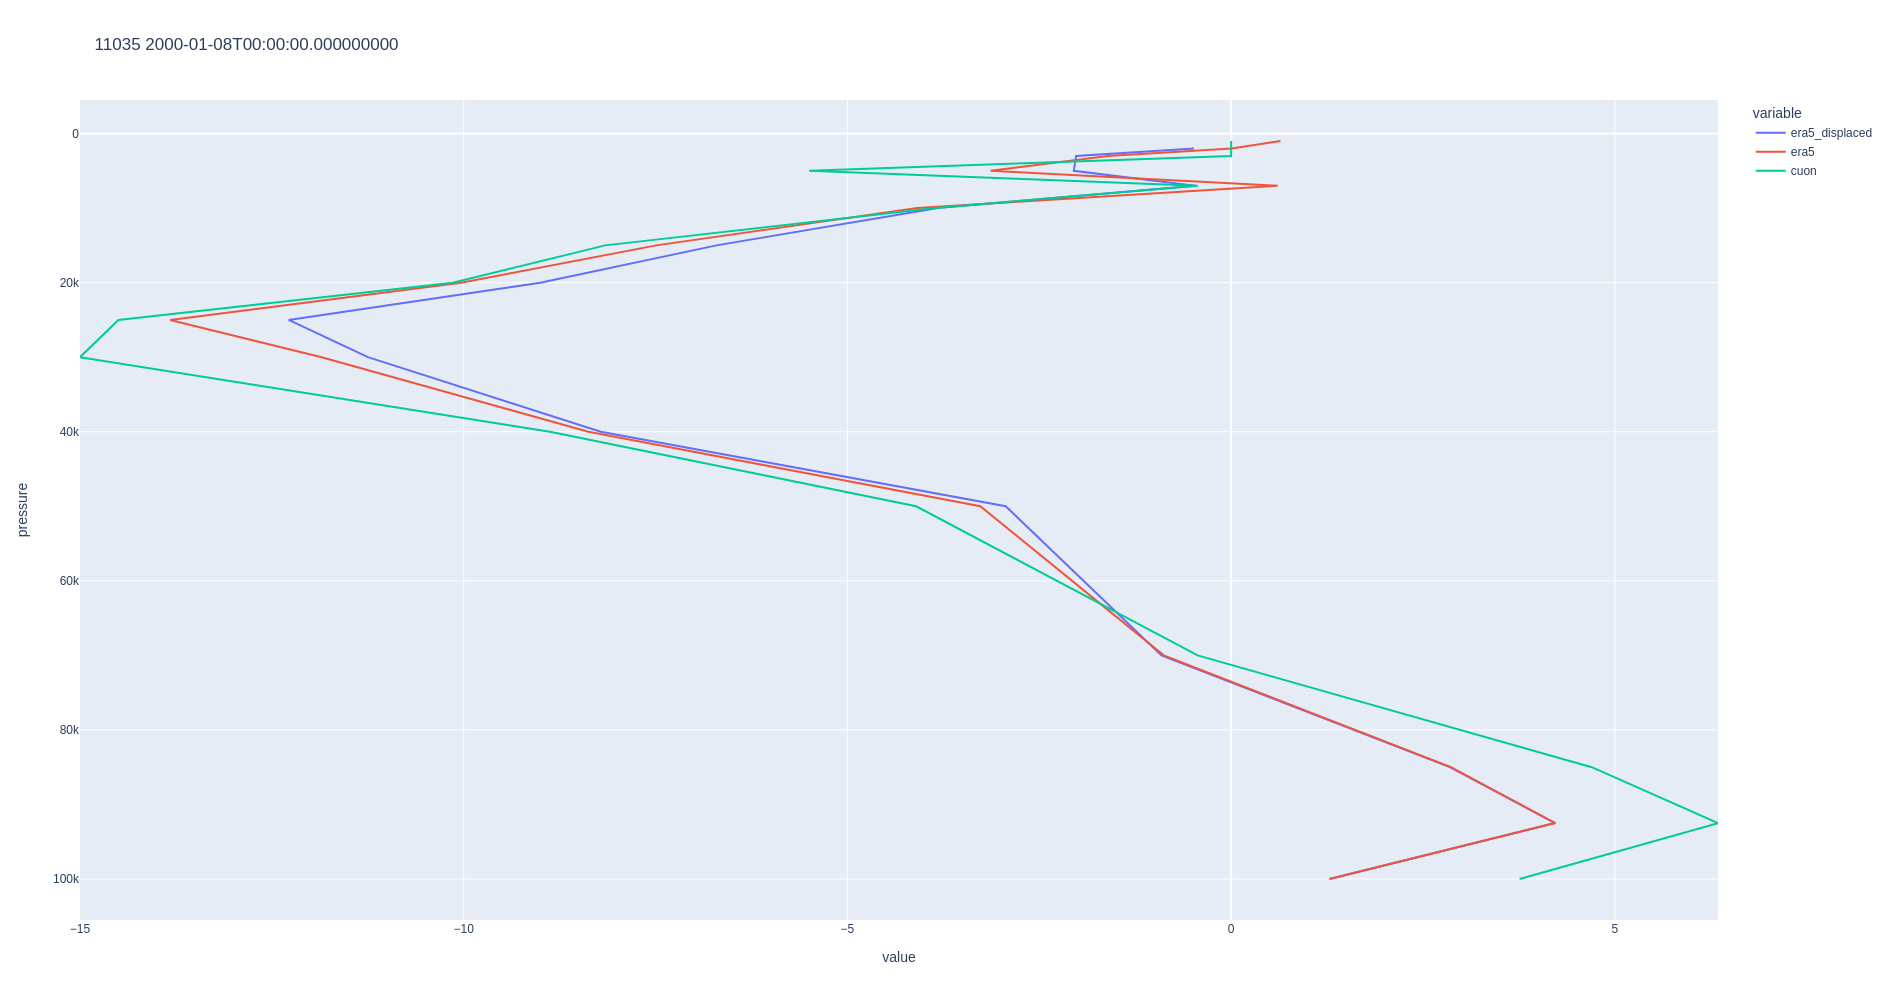

In [108]:
year = 2000
mon = 1
sid = '11035'
conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/*' + sid + '*_CEUAS_merged_v1.nc')[0]

dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

df_dict = {}
h_df_dict = {}

with h5py.File(conv_file, 'r') as file:
    rts = file['recordindices']['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    if len(idx) == 0:
        print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)

    h_idx = file['recordindices']['140'][idx]
    t_idx = file['recordindices']['126'][idx]
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]


    mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
    mask = np.isin(mask,plevs)

    h_mask = file['observations_table']['z_coordinate'][h_idx[0]:h_idx[-1]]
    h_mask = np.isin(h_mask,plevs)

    t_len = len(mask[mask == True])

    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
#             df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
    df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
    df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
    repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
    df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

    df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
    df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
    df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

    h_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][h_idx[0]:h_idx[-1]][h_mask])
    h_df_dict['date_time'] = list(file['observations_table']['date_time'][h_idx[0]:h_idx[-1]][h_mask])
    h_df_dict['observation_value'] = list(file['observations_table']['observation_value'][h_idx[0]:h_idx[-1]][h_mask])

    df_dict['variable'] = ['v']*t_len

    df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
    df = pd.DataFrame.from_dict(df_dict)

    h_df_dict['date_time'] = seconds_to_datetime(h_df_dict['date_time'])
    h_df = pd.DataFrame.from_dict(h_df_dict)

    # put dfs together:
    df = df.merge(h_df, how='inner', on=['date_time','z_coordinate'])


files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(mon).zfill(2)+'*.132.nc')[0]
ds_fc = xr.load_dataset(files)

look_at = df[df.date_time.dt.month == mon]
look_at = np.unique(look_at.date_time)
for i in look_at[:15]:
    var_list = []
    undis_list = []
    cuon_list = []
    cuon_press = []
    
    out_dict = {}
    ds_fc_time = ds_fc.sel(time=i, method='nearest')
    station_lat = df.latitude.iloc[0]
    station_lon = df.longitude.iloc[0]
    lon = station_lon
    if lon < 0:
        lon = 360.+lon
    ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
    undis_list = np.array(ds_now.v)
    
    for j in np.array(ds_fc_time.level): #10,20,...,1000
        step = find_nearest(df.z_coordinate, j*100)
        input_data_step = df[df.z_coordinate == step]
        station_lat = df.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]
        station_lon = df.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
        lon = station_lon
        if lon < 0:
            lon = 360.+lon

        
        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
        var = ds_now.v.sel(level = j)
        var_list.append(float(var))
        cv = df[np.logical_and(df.date_time == i,  df.z_coordinate == step)].observation_value.values
        cuon_list.append((np.nan if len(cv) == 0 else float(cv[0])))
        cuon_press.append(step)
        
    out_dict['era5_displaced'] = drop_dims(var_list)
    out_dict['era5'] = drop_dims(undis_list)
    out_dict['cuon'] = drop_dims(cuon_list)
    
    out_dict['pressure'] = drop_dims(ds_fc_time.level) * 100.
    out_dict['cuon_pressure']= drop_dims(cuon_press)
    out_df = pd.DataFrame.from_dict(out_dict)

    lineplt = px.line(
        title = str(sid) + ' ' + str(i),
        data_frame = out_df,
        x=['era5_displaced', 'era5', 'cuon'],
        y='pressure',
        # color= 'Country',
        hover_name='pressure',
        width= 1000, height=1000,
        # color_discrete_sequence=['rgb(23, 153, 59)','rgb(214, 163, 21)','rgb(40, 48, 165)', 'rgb(210, 0, 38)'],
    )
    lineplt['layout']['yaxis']['autorange'] = "reversed"
    lineplt.show()
    

In [ ]:
year = 2000
mon = 1
sid = '11035'
conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/*' + sid + '*_CEUAS_merged_v1.nc')[0]

dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

df_dict = {}
h_df_dict = {}

with h5py.File(conv_file, 'r') as file:
    rts = file['recordindices']['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    if len(idx) == 0:
        print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)

    h_idx = file['recordindices']['139'][idx]
    t_idx = file['recordindices']['126'][idx]
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]


    mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
    mask = np.isin(mask,plevs)

    h_mask = file['observations_table']['z_coordinate'][h_idx[0]:h_idx[-1]]
    h_mask = np.isin(h_mask,plevs)

    t_len = len(mask[mask == True])

    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
#             df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
    df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
    df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
    repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
    df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

    df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
    df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
    df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

    h_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][h_idx[0]:h_idx[-1]][h_mask])
    h_df_dict['date_time'] = list(file['observations_table']['date_time'][h_idx[0]:h_idx[-1]][h_mask])
    h_df_dict['observation_value'] = list(file['observations_table']['observation_value'][h_idx[0]:h_idx[-1]][h_mask])

    df_dict['variable'] = ['v']*t_len

    df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
    df = pd.DataFrame.from_dict(df_dict)

    h_df_dict['date_time'] = seconds_to_datetime(h_df_dict['date_time'])
    h_df = pd.DataFrame.from_dict(h_df_dict)

    # put dfs together:
    df = df.merge(h_df, how='inner', on=['date_time','z_coordinate'])


files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(mon).zfill(2)+'*.132.nc')[0]
ds_fc = xr.load_dataset(files)

look_at = df[df.date_time.dt.month == mon]
look_at = np.unique(look_at.date_time)
for i in look_at[:15]:
    var_list = []
    undis_list = []
    cuon_list = []
    cuon_press = []
    
    out_dict = {}
    ds_fc_time = ds_fc.sel(time=i, method='nearest')
    station_lat = df.latitude.iloc[0]
    station_lon = df.longitude.iloc[0]
    lon = station_lon
    if lon < 0:
        lon = 360.+lon
    ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
    undis_list = np.array(ds_now.v)
    
    for j in np.array(ds_fc_time.level): #10,20,...,1000
        step = find_nearest(df.z_coordinate, j*100)
        input_data_step = df[df.z_coordinate == step]
        station_lat = df.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]
        station_lon = df.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
        lon = station_lon
        if lon < 0:
            lon = 360.+lon

        
        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
        var = ds_now.v.sel(level = j)
        var_list.append(float(var))
        cv = df[np.logical_and(df.date_time == i,  df.z_coordinate == step)].observation_value.values
        cuon_list.append((np.nan if len(cv) == 0 else float(cv[0])))
        cuon_press.append(step)
        
    out_dict['era5_displaced'] = drop_dims(var_list)
    out_dict['era5'] = drop_dims(undis_list)
    out_dict['cuon'] = drop_dims(cuon_list)
    
    out_dict['pressure'] = drop_dims(ds_fc_time.level) * 100.
    out_dict['cuon_pressure']= drop_dims(cuon_press)
    out_df = pd.DataFrame.from_dict(out_dict)

    lineplt = px.line(
        title = str(sid) + ' ' + str(i),
        data_frame = out_df,
        x=['era5_displaced', 'era5', 'cuon'],
        y='pressure',
        # color= 'Country',
        hover_name='pressure',
        width= 1000, height=1000,
        # color_discrete_sequence=['rgb(23, 153, 59)','rgb(214, 163, 21)','rgb(40, 48, 165)', 'rgb(210, 0, 38)'],
    )
    lineplt['layout']['yaxis']['autorange'] = "reversed"
    lineplt.show()
    

In [97]:
out_df

,era5_displaced,era5,cuon,pressure,cuon_pressure
0,2.327043,6.599079,NaN,1000.0,1000.0
1,7.624808,7.503764,NaN,2000.0,2000.0
2,10.413554,10.205155,36.859203,3000.0,3000.0
3,7.715236,9.543031,29.885841,5000.0,5000.0
4,9.076183,9.108226,24.620193,7000.0,7000.0
5,10.984727,10.608481,14.488888,10000.0,10000.0
6,13.373085,12.583600,17.854160,15000.0,15000.0
7,14.353759,13.184678,16.914467,20000.0,20000.0
8,12.810933,11.671628,21.297953,25000.0,25000.0
9,12.869077,12.429174,19.917156,30000.0,30000.0


In [41]:
undis_list.reshape()flatten()

array([14.17377851, 15.51925622, 18.59532102, 25.20482479, 29.15550479,
       25.05850861, 24.98092437, 23.09036804, 23.62125107, 20.19012695,
       16.35775046, 12.8530231 ,  9.29385183,  5.74726214,  3.20873402,
        2.05549003])

In [46]:
drop_dims(undis_list)

array([14.17377851, 15.51925622, 18.59532102, 25.20482479, 29.15550479,
       25.05850861, 24.98092437, 23.09036804, 23.62125107, 20.19012695,
       16.35775046, 12.8530231 ,  9.29385183,  5.74726214,  3.20873402,
        2.05549003])